In [1]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from data_treatment import CreditCardDataSet
from discriminator import *
from generator import *
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import glob

In [2]:
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): 
        return n.cuda() 
    return n

In [3]:
files_dropdown = widgets.Dropdown(
    options=glob.glob("*.csv"),
    description='File:',
    value = 'diabetes.csv',
    disabled=False,
)
display(files_dropdown)

Dropdown(description='File:', index=2, options=('creditcard.csv', 'data.csv', 'diabetes.csv'), value='diabetes…

In [4]:
file_name=files_dropdown.value
if file_name == "data.csv":
    message = "Breast Cancer Wisconsin (Diagnostic) Data Set"
    class_name = "diagnosis"
    values_names = {0: "Benign", 1: "Malignant"}
    class_len = 33
elif file_name == "creditcard.csv":
    message = "Credit Card Fraud Detection"
    class_name = "Class"
    values_names = {0: "No Frauds", 1: "Frauds"}
    class_len = 31
elif file_name == "diabetes.csv":
    message="Pima Indians Diabetes Database"
    class_name = "Outcome"
    values_names = {0: "Normal", 1: "Diabets"}
    class_len = 9
else:
     exit()

In [5]:
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [6]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [7]:
lr = 0.0002
#lr= 0.0002
d_steps = 1
batch_size = 5
num_epochs = 1000
print_interval = 100
num_test_samples = 16
loss = nn.BCELoss()

In [8]:
discriminator = DiscriminatorNet(class_len)
generator = GeneratorNet(class_len)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

In [9]:
d_error_plt = [0]
g_error_plt = [0]

generated_points = []

In [10]:

test_noise = noise(num_test_samples)
database = CreditCardDataSet (csv_file=file_name, root_dir=".")

data_loader = torch.utils.data.DataLoader(database, batch_size=batch_size, shuffle=True)

num_batches = len(data_loader)

In [11]:
for epoch in range(num_epochs):
    print("Epoch ", epoch)

    for n_batch, real_batch in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(real_batch).float()
        if torch.cuda.is_available(): 
            real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        generated_points.append(fake_data)
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Display Progress

        #if (n_batch) % print_interval == 0:
    filename = "results/" + file_name[:-4] + "/" + str(epoch) + "_" + str(n_batch) + ".txt"
    print(filename)
    file = open(filename, "w")
    flt_d_error = d_error
    flt_g_error = g_error
    print("Discriminator error: ", flt_d_error)
    print("Generator error: ", flt_g_error)
    print("")

    file.write("Discriminator error: " + str(flt_d_error) + "\n")
    file.write("Generator error: " + str(flt_g_error) + "\n")
    file.write("Points: " + str(fake_data) + "\n\n\n")

    d_error_plt.append(flt_d_error)
    g_error_plt.append(flt_g_error)
        #     #display.clear_output(True)
        #     # Display Images
        #     test_images = generator(test_noise).data.cpu()
        #     logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
        #     # Display status Logs
        #     #logger.display_status(epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake)
        # # Model Checkpoints


Epoch  0
results/diabetes/0_153.txt
Discriminator error:  tensor(0.8009, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  1
results/diabetes/1_153.txt
Discriminator error:  tensor(0.6844, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.1153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  2
results/diabetes/2_153.txt
Discriminator error:  tensor(0.4692, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.1032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  3
results/diabetes/3_153.txt
Discriminator error:  tensor(0.7619, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.1187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  4
results/diabetes/4_153.txt
Discriminator error:  tensor(1.1564, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8341, device='cuda:0', grad_fn=<BinaryCros

results/diabetes/40_153.txt
Discriminator error:  tensor(1.0095, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  41
results/diabetes/41_153.txt
Discriminator error:  tensor(0.4830, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(2.1915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  42
results/diabetes/42_153.txt
Discriminator error:  tensor(0.7530, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  43
results/diabetes/43_153.txt
Discriminator error:  tensor(1.9218, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  44
results/diabetes/44_153.txt
Discriminator error:  tensor(1.4617, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.1980, device='cuda:0', grad_fn=<BinaryCros

results/diabetes/80_153.txt
Discriminator error:  tensor(1.8815, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.1297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  81
results/diabetes/81_153.txt
Discriminator error:  tensor(1.1723, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  82
results/diabetes/82_153.txt
Discriminator error:  tensor(1.5319, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  83
results/diabetes/83_153.txt
Discriminator error:  tensor(1.7401, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  84
results/diabetes/84_153.txt
Discriminator error:  tensor(1.1833, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8794, device='cuda:0', grad_fn=<BinaryCros

results/diabetes/120_153.txt
Discriminator error:  tensor(0.8503, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.0107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  121
results/diabetes/121_153.txt
Discriminator error:  tensor(1.1620, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  122
results/diabetes/122_153.txt
Discriminator error:  tensor(1.4114, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  123
results/diabetes/123_153.txt
Discriminator error:  tensor(1.4060, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  124
results/diabetes/124_153.txt
Discriminator error:  tensor(1.0615, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.0636, device='cuda:0', grad_fn=<B

results/diabetes/160_153.txt
Discriminator error:  tensor(1.3635, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  161
results/diabetes/161_153.txt
Discriminator error:  tensor(1.1542, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  162
results/diabetes/162_153.txt
Discriminator error:  tensor(0.7528, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  163
results/diabetes/163_153.txt
Discriminator error:  tensor(1.4512, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  164
results/diabetes/164_153.txt
Discriminator error:  tensor(1.3492, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.0365, device='cuda:0', grad_fn=<B

results/diabetes/200_153.txt
Discriminator error:  tensor(1.8909, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  201
results/diabetes/201_153.txt
Discriminator error:  tensor(1.4834, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  202
results/diabetes/202_153.txt
Discriminator error:  tensor(1.2136, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  203
results/diabetes/203_153.txt
Discriminator error:  tensor(1.5015, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  204
results/diabetes/204_153.txt
Discriminator error:  tensor(1.5353, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8249, device='cuda:0', grad_fn=<B

results/diabetes/240_153.txt
Discriminator error:  tensor(1.5284, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  241
results/diabetes/241_153.txt
Discriminator error:  tensor(1.2832, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  242
results/diabetes/242_153.txt
Discriminator error:  tensor(1.2541, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  243
results/diabetes/243_153.txt
Discriminator error:  tensor(0.7849, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  244
results/diabetes/244_153.txt
Discriminator error:  tensor(1.4432, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8908, device='cuda:0', grad_fn=<B

results/diabetes/280_153.txt
Discriminator error:  tensor(1.6423, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  281
results/diabetes/281_153.txt
Discriminator error:  tensor(1.3635, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.1453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  282
results/diabetes/282_153.txt
Discriminator error:  tensor(1.2797, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  283
results/diabetes/283_153.txt
Discriminator error:  tensor(1.3661, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  284
results/diabetes/284_153.txt
Discriminator error:  tensor(1.2832, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9779, device='cuda:0', grad_fn=<B

results/diabetes/320_153.txt
Discriminator error:  tensor(1.3753, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  321
results/diabetes/321_153.txt
Discriminator error:  tensor(1.3263, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  322
results/diabetes/322_153.txt
Discriminator error:  tensor(1.3942, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  323
results/diabetes/323_153.txt
Discriminator error:  tensor(1.3788, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  324
results/diabetes/324_153.txt
Discriminator error:  tensor(1.1094, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9845, device='cuda:0', grad_fn=<B

results/diabetes/360_153.txt
Discriminator error:  tensor(1.3281, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  361
results/diabetes/361_153.txt
Discriminator error:  tensor(1.4966, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  362
results/diabetes/362_153.txt
Discriminator error:  tensor(1.5231, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  363
results/diabetes/363_153.txt
Discriminator error:  tensor(1.4384, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  364
results/diabetes/364_153.txt
Discriminator error:  tensor(1.3125, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5818, device='cuda:0', grad_fn=<B

results/diabetes/400_153.txt
Discriminator error:  tensor(1.4436, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  401
results/diabetes/401_153.txt
Discriminator error:  tensor(1.3010, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  402
results/diabetes/402_153.txt
Discriminator error:  tensor(1.8731, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  403
results/diabetes/403_153.txt
Discriminator error:  tensor(1.2911, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  404
results/diabetes/404_153.txt
Discriminator error:  tensor(1.2141, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6749, device='cuda:0', grad_fn=<B

results/diabetes/440_153.txt
Discriminator error:  tensor(1.4106, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  441
results/diabetes/441_153.txt
Discriminator error:  tensor(1.4236, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  442
results/diabetes/442_153.txt
Discriminator error:  tensor(1.1989, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  443
results/diabetes/443_153.txt
Discriminator error:  tensor(1.0287, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  444
results/diabetes/444_153.txt
Discriminator error:  tensor(1.3185, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7278, device='cuda:0', grad_fn=<B

results/diabetes/480_153.txt
Discriminator error:  tensor(1.4521, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  481
results/diabetes/481_153.txt
Discriminator error:  tensor(1.2418, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  482
results/diabetes/482_153.txt
Discriminator error:  tensor(1.4021, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  483
results/diabetes/483_153.txt
Discriminator error:  tensor(1.3976, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  484
results/diabetes/484_153.txt
Discriminator error:  tensor(1.2283, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8085, device='cuda:0', grad_fn=<B

results/diabetes/520_153.txt
Discriminator error:  tensor(1.3366, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  521
results/diabetes/521_153.txt
Discriminator error:  tensor(1.4366, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.4401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  522
results/diabetes/522_153.txt
Discriminator error:  tensor(1.1759, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  523
results/diabetes/523_153.txt
Discriminator error:  tensor(1.7285, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  524
results/diabetes/524_153.txt
Discriminator error:  tensor(1.1686, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7083, device='cuda:0', grad_fn=<B

results/diabetes/560_153.txt
Discriminator error:  tensor(1.2464, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.0438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  561
results/diabetes/561_153.txt
Discriminator error:  tensor(1.3273, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  562
results/diabetes/562_153.txt
Discriminator error:  tensor(1.1456, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  563
results/diabetes/563_153.txt
Discriminator error:  tensor(1.3368, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  564
results/diabetes/564_153.txt
Discriminator error:  tensor(1.2318, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6122, device='cuda:0', grad_fn=<B

results/diabetes/600_153.txt
Discriminator error:  tensor(1.5787, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  601
results/diabetes/601_153.txt
Discriminator error:  tensor(1.6030, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  602
results/diabetes/602_153.txt
Discriminator error:  tensor(1.4940, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  603
results/diabetes/603_153.txt
Discriminator error:  tensor(1.0998, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7723, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  604
results/diabetes/604_153.txt
Discriminator error:  tensor(1.4547, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8562, device='cuda:0', grad_fn=<B

results/diabetes/640_153.txt
Discriminator error:  tensor(1.5904, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  641
results/diabetes/641_153.txt
Discriminator error:  tensor(1.5665, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  642
results/diabetes/642_153.txt
Discriminator error:  tensor(1.3739, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6721, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  643
results/diabetes/643_153.txt
Discriminator error:  tensor(1.6170, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  644
results/diabetes/644_153.txt
Discriminator error:  tensor(0.9460, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5515, device='cuda:0', grad_fn=<B

results/diabetes/680_153.txt
Discriminator error:  tensor(1.5770, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  681
results/diabetes/681_153.txt
Discriminator error:  tensor(1.1283, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  682
results/diabetes/682_153.txt
Discriminator error:  tensor(1.2450, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  683
results/diabetes/683_153.txt
Discriminator error:  tensor(1.3521, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  684
results/diabetes/684_153.txt
Discriminator error:  tensor(1.3685, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7245, device='cuda:0', grad_fn=<B

results/diabetes/720_153.txt
Discriminator error:  tensor(1.2570, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  721
results/diabetes/721_153.txt
Discriminator error:  tensor(1.0109, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  722
results/diabetes/722_153.txt
Discriminator error:  tensor(1.2390, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  723
results/diabetes/723_153.txt
Discriminator error:  tensor(1.4711, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  724
results/diabetes/724_153.txt
Discriminator error:  tensor(1.2441, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8619, device='cuda:0', grad_fn=<B

results/diabetes/760_153.txt
Discriminator error:  tensor(1.5498, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  761
results/diabetes/761_153.txt
Discriminator error:  tensor(1.3012, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  762
results/diabetes/762_153.txt
Discriminator error:  tensor(1.5895, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  763
results/diabetes/763_153.txt
Discriminator error:  tensor(1.5536, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6718, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  764
results/diabetes/764_153.txt
Discriminator error:  tensor(1.5044, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6900, device='cuda:0', grad_fn=<B

results/diabetes/800_153.txt
Discriminator error:  tensor(1.2846, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  801
results/diabetes/801_153.txt
Discriminator error:  tensor(1.2740, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  802
results/diabetes/802_153.txt
Discriminator error:  tensor(1.4112, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(1.0968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  803
results/diabetes/803_153.txt
Discriminator error:  tensor(1.5718, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  804
results/diabetes/804_153.txt
Discriminator error:  tensor(1.4375, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8786, device='cuda:0', grad_fn=<B

results/diabetes/840_153.txt
Discriminator error:  tensor(1.3067, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  841
results/diabetes/841_153.txt
Discriminator error:  tensor(0.9156, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  842
results/diabetes/842_153.txt
Discriminator error:  tensor(1.6008, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  843
results/diabetes/843_153.txt
Discriminator error:  tensor(1.3811, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  844
results/diabetes/844_153.txt
Discriminator error:  tensor(1.3912, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5786, device='cuda:0', grad_fn=<B

results/diabetes/880_153.txt
Discriminator error:  tensor(1.1250, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  881
results/diabetes/881_153.txt
Discriminator error:  tensor(1.3013, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6589, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  882
results/diabetes/882_153.txt
Discriminator error:  tensor(1.2940, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  883
results/diabetes/883_153.txt
Discriminator error:  tensor(1.4251, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  884
results/diabetes/884_153.txt
Discriminator error:  tensor(1.6041, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8736, device='cuda:0', grad_fn=<B

results/diabetes/920_153.txt
Discriminator error:  tensor(1.2960, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  921
results/diabetes/921_153.txt
Discriminator error:  tensor(1.3672, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  922
results/diabetes/922_153.txt
Discriminator error:  tensor(1.3553, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  923
results/diabetes/923_153.txt
Discriminator error:  tensor(1.4439, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  924
results/diabetes/924_153.txt
Discriminator error:  tensor(1.4599, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7501, device='cuda:0', grad_fn=<B

results/diabetes/960_153.txt
Discriminator error:  tensor(1.2785, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.8315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  961
results/diabetes/961_153.txt
Discriminator error:  tensor(1.1772, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.7320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  962
results/diabetes/962_153.txt
Discriminator error:  tensor(1.5975, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6742, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  963
results/diabetes/963_153.txt
Discriminator error:  tensor(1.1692, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.6274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch  964
results/diabetes/964_153.txt
Discriminator error:  tensor(1.1737, device='cuda:0', grad_fn=<ThAddBackward>)
Generator error:  tensor(0.9015, device='cuda:0', grad_fn=<B

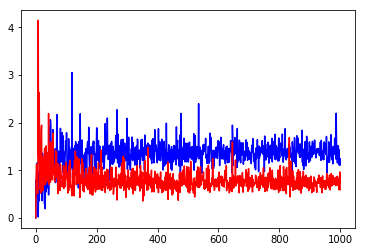

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(d_error_plt, 'b')
plt.plot(g_error_plt, 'r')
filename = "results/" + file_name[:-4] + "/" + "error_growth.txt"
file = open(filename, "w")
file.write("Discriminator error: " + str(d_error_plt) + "\n")
file.write("\n\n\n")
file.write("Generator error: " + str(g_error_plt) + "\n")
file.close()

plt.savefig('images/'+ file_name[:-4] + "/"+ 'error.png')
plt.show()
plt.clf()

In [13]:
points_collection = []
for batch in generated_points:
    if batch[0].size() != []:
        for point in batch:
            point = point.cpu().detach().numpy()
            points_collection.append(point)

In [14]:
df = pd.DataFrame(points_collection, columns=database.get_columns()).round(2)
df.to_csv( "fake_data/" + file_name[:-4] + "_" + str(epoch) + ".csv")